In [1]:
import numpy as np
from matplotlib import pyplot as plt

import math

import torch
from torch import nn

import pandas_datareader as pdr
from sklearn.metrics import mean_squared_error

In [2]:
GOOG_data = pdr.DataReader('GOOG','stooq')

In [3]:
GOOG = GOOG_data.reset_index()
GOOG = GOOG[(GOOG['Date'] >= '2023-01-01') & (GOOG['Date'] <= '2023-12-31')]
GOOG = GOOG.reset_index().drop('index', axis=1)
GOOG.head(2)

,Date,Open,High,Low,Close,Volume
0,2023-12-29,140.68,141.435,139.9000,140.93,14880961
1,2023-12-28,141.85,142.270,140.8283,141.28,12192549


In [4]:
GOOG_st = GOOG['Close'].diff().dropna().reset_index()['Close']

In [5]:
interval = 10
Close = GOOG_st

x = torch.Tensor(Close[:-interval])
y = torch.Tensor(Close.shift(-interval).dropna().reset_index()['Close'])
len(x), len(y)

(239, 239)

In [6]:
x[:11]

tensor([ 0.3500,  0.1600,  1.3800, -0.1000, -0.9200, -2.1400, -1.5600, -0.9100,
        -3.3500, -0.6400,  0.7700])

In [7]:
i = 0
x[i:i+interval], y[i]

(tensor([ 0.3500,  0.1600,  1.3800, -0.1000, -0.9200, -2.1400, -1.5600, -0.9100,
         -3.3500, -0.6400]),
 tensor(0.7700))

In [8]:
t_x = torch.tensor([x.tolist()[i:i+interval] for i in range(len(x.tolist()))][:-interval])
t_x[i], y[i]

(tensor([ 0.3500,  0.1600,  1.3800, -0.1000, -0.9200, -2.1400, -1.5600, -0.9100,
         -3.3500, -0.6400]),
 tensor(0.7700))

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # [185, 128]
        self.i2o = nn.Linear(input_size + hidden_size, output_size)  # [185, 18]
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        if (len(input_tensor.shape) == 1):
            input_tensor = input_tensor.unsqueeze(0)
            
        combined = torch.cat((input_tensor, hidden_tensor), 1)  # [1, 57] + [1, 128] = [1, 185]

        hidden = self.i2h(combined)  # [1, 128]
        output = self.i2o(combined)  # [1, 18]
        # output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)  # [1, 57]

In [10]:
rnn = RNN(interval, 64, 1)
hidd_tensor = rnn.init_hidden()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.01)

c:\Users\timashan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def train(x):
  h = rnn.init_hidden()
  for _ in range(1000):
    for i in range(x.size()[0]):
      out, h = rnn(x[i], h)

    loss = criterion(out, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return out, loss.item()

out, loss = train(t_x)
print(loss)

c:\Users\timashan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([239])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


5.8550944328308105


## Testing

In [16]:
GOOG_test = GOOG_data.reset_index()
GOOG_test = GOOG_test[(GOOG_test['Date'] >= '2024-01-01') & (GOOG_test['Date'] <= '2024-12-31')]
GOOG_test_st = GOOG_test['Close'].diff().dropna().reset_index()['Close']

X_test = torch.Tensor(GOOG_test_st)
X_test = torch.tensor([X_test.tolist()[i:i+interval] for i in range(len(X_test.tolist()))][:-interval])
y_test = torch.Tensor(GOOG_test_st.shift(-interval).dropna().reset_index()['Close'])
len(X_test), len(y_test)

(126, 126)

In [17]:
pred = []
h = rnn.init_hidden()
for i in range(X_test.size()[0]):
    out, h = rnn.forward(X_test[i], h)
    pred.append(out.item())

math.sqrt(mean_squared_error(y_test, pred))

3.015027422739761

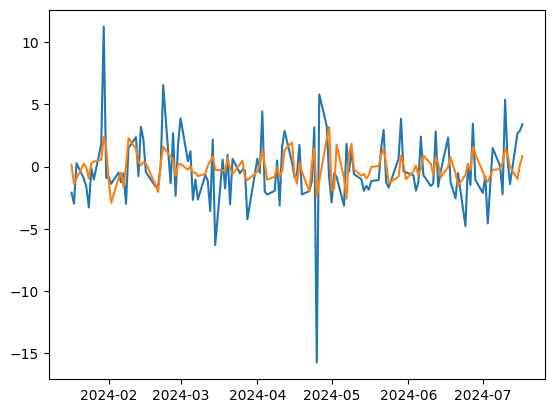

In [18]:
plt.plot(GOOG_test['Date'][1:-interval], GOOG_test_st[:-interval])
plt.plot(GOOG_test['Date'][1:-interval], pred)

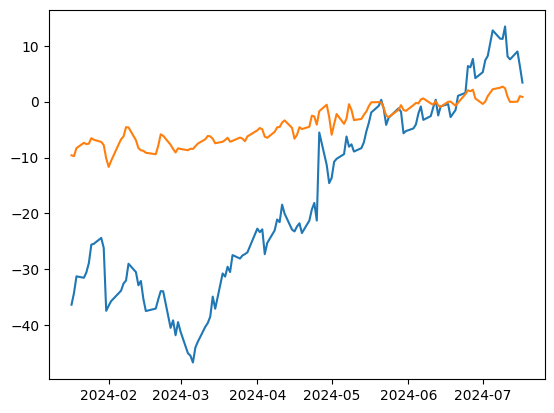

In [19]:
plt.plot(GOOG_test['Date'][1:-interval], np.cumsum(GOOG_test_st[:-interval]))
plt.plot(GOOG_test['Date'][1:-interval], np.cumsum(pred))